In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

import pdb
from tqdm import tqdm

from torchsummary import summary

from bayesnn.models.bbb_het_reg import BBBHetRegModel
from bayesnn.models.bbb_het_reg_dual import BBBHetRegDualModel

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
def true_f(x, e=0):
    return x + 0.3 * np.sin(2 * np.pi * (x + e)) + 0.3 * np.sin(4. * np.pi * (x + e))
    #return np.sin(12.0 * x) + 0.66 * np.cos(25.0 * x) + 3.0
    #return np.sin(x)


def get_data(train_size=100, test_size=100):
    n = train_size + test_size

    np.random.seed(42)

    #X = np.linspace(-2.0, 2.0, num=n)
    X = np.random.uniform(-1.0, 1.0, n)
    e = np.random.normal(0, 0.02, n)
    Y = true_f(X, e=e) + e

    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

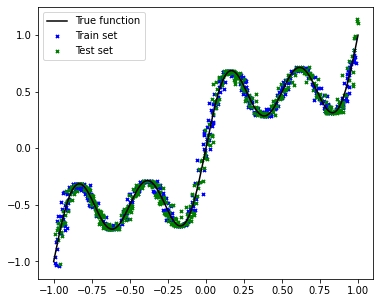

In [4]:
true_x = np.linspace(-1.0, 1.0, 1000)
true_y = true_f(true_x, e=0)

X_train, y_train, X_test, y_test = get_data(500, 500)

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_train, y_train, s=10, marker='x', color='blue', label='Train set')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.legend()

plt.show()

In [5]:
n_hidden = 5

model_reg = BBBHetRegDualModel(hidden_size=n_hidden, act_func=F.tanh).to(device)

params_reg = list(model_reg.parameters())
optimizer_reg = torch.optim.Adam(params_reg, lr=0.01)

X_train_tensor = torch.from_numpy(X_train.reshape((-1, 1))).float().to(device)
y_train_tensor = torch.from_numpy(y_train.reshape((-1, 1))).float().to(device)

X_test_tensor = torch.from_numpy(X_test.reshape((-1, 1))).float().to(device)
y_test_tensor = torch.from_numpy(y_test.reshape((-1, 1))).float().to(device)

loss_fn = nn.MSELoss()

In [6]:
num_epoches = 3000
num_samples = 10

model_reg.train(True)
#model_reg.train(False)

for ep in tqdm(range(num_epoches)):
    optimizer_reg.zero_grad()
    log_likelihood_total = 0
    kl_total = 0

    for i in range(num_samples):
        out_mu, out_sigma, out_kl = model_reg(X_train_tensor, sample=True)
        #kl_total += out_kl
        kl_total = out_kl

        log_likelihood = torch.distributions.Normal(loc=out_mu, scale=out_sigma).log_prob(y_train_tensor).sum()
        log_likelihood_total += log_likelihood

    #elbo = (log_likelihood_total - kl_total) / (num_samples * x_train.shape[0])
    log_likelihood_total_s = log_likelihood_total / num_samples
    elbo = log_likelihood_total_s - kl_total
    (-elbo).backward()

    optimizer_reg.step()
    #optimizer_reg.zero_grad()

    if (ep + 1) % 50 == 0:
        print(f'Epoch {ep} | '
              f'ELBO {elbo.cpu().detach().numpy()} | '
              f'LL {log_likelihood_total_s.cpu().detach().numpy()} | '
              f'KL {kl_total.cpu().detach().numpy() if isinstance(kl_total, torch.Tensor) else kl_total}')

        with torch.no_grad():
            y_pred, _, _ = model_reg(X_test_tensor, sample=False)
            mse = loss_fn(y_pred, y_test_tensor).mean().cpu().detach().numpy()

        print(f"MSE {mse}")

  0%|          | 0/3000 [00:00<?, ?it/s]C:\Users\Alex\anaconda3\envs\bayesnn\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 3000/3000 [13:17<00:00,  3.76it/s]


Epoch 49 | ELBO -413.2306823730469 | LL -55.138912200927734 | KL 358.0917663574219
MSE 0.08080486208200455
Epoch 99 | ELBO -390.0662536621094 | LL -38.71469497680664 | KL 351.3515625
MSE 0.08170770108699799
Epoch 149 | ELBO -375.6501770019531 | LL -35.34670639038086 | KL 340.303466796875
MSE 0.08065523952245712
Epoch 199 | ELBO -352.5926208496094 | LL -28.270837783813477 | KL 324.32177734375
MSE 0.07851849496364594
Epoch 249 | ELBO -310.634033203125 | LL -5.826292991638184 | KL 304.8077392578125
MSE 0.07179034501314163
Epoch 299 | ELBO -226.93316650390625 | LL 57.156917572021484 | KL 284.090087890625
MSE 0.05521931126713753
Epoch 349 | ELBO -169.03590393066406 | LL 94.31886291503906 | KL 263.3547668457031
MSE 0.044486235827207565
Epoch 399 | ELBO -140.06195068359375 | LL 102.45401763916016 | KL 242.51596069335938
MSE 0.042627137154340744
Epoch 449 | ELBO -110.46853637695312 | LL 111.8394775390625 | KL 222.30801391601562
MSE 0.04097920283675194
Epoch 499 | ELBO -79.37882232666016 | LL 1

In [7]:
n_samples = 100
model_reg.train(False)

samples_m = np.zeros((X_test_tensor.shape[0], n_samples))
samples_s = np.zeros_like(samples_m)
for i in range(n_samples):
    mus, sigmas, _ = model_reg(X_test_tensor, sample=False)
    np_m = mus.cpu().data.numpy()
    np_s = sigmas.cpu().data.numpy()
    samples_m[:, i] = np_m[:, 0]
    samples_s[:, i] = np_s[:, 0]

y_pred = samples_m.mean(axis=1)
#y_err = np.array(samples_m).std(axis=0)
y_err = samples_s.mean(axis=1)

print(model_reg(torch.tensor([[-1.0], [0.0], [1.0]], device=device), sample=False))

(tensor([[-0.5788],
        [ 0.0301],
        [ 0.5704]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([[0.2027],
        [0.0909],
        [0.1892]], device='cuda:0', grad_fn=<SoftplusBackward>), 0)


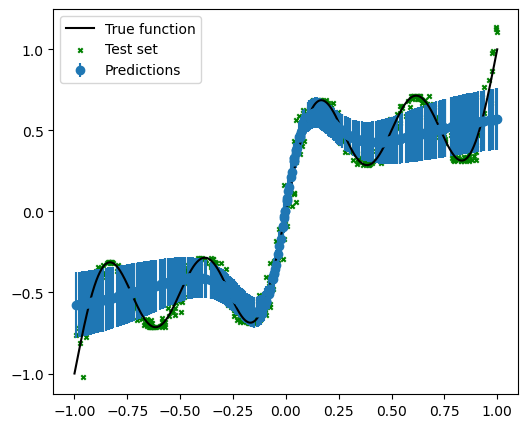

In [8]:
plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')
#plt.scatter(X_test, y_pred, s=10, marker='o', label='Predictions')

plt.errorbar(X_test, y_pred, yerr=y_err, fmt='o', ls='none', label='Predictions')

plt.legend()

plt.show()

In [9]:
model_simple =  nn.Sequential(
          nn.Linear(1, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, 1)
        ).to(device)

class Reg2L(nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.n_hidden = n_hidden
        self.layer1 = nn.Linear(1, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, 2)

    def forward(self, input):
        h1 = self.layer1(input)
        h2 = self.layer2(F.tanh(h1))
        h3 = self.layer3(F.tanh(h2))
        m = h3[:, 0]
        s = F.elu(h3[:, 1]) + 1.
        return m, s

class Reg2N(nn.Module):
    def __init__(self, n_hidden=10, activation=nn.ReLU):
        super().__init__()
        self.n_hidden = n_hidden
        self.activation = activation
        self.mu_net = nn.Sequential(
            nn.Linear(1, n_hidden),
            activation(),
            nn.Linear(n_hidden, n_hidden),
            activation(),
            nn.Linear(n_hidden, 1)
        )

        self.sigma_net = nn.Sequential(
            nn.Linear(1, n_hidden),
            activation(),
            nn.Linear(n_hidden, n_hidden),
            activation(),
            nn.Linear(n_hidden, 1),
            nn.Softplus()
        )

    def forward(self, input):
        return self.mu_net(input), self.sigma_net(input)

model_simple = Reg2N(n_hidden=n_hidden, activation=nn.Tanh).to(device)
#optimizer_simple = torch.optim.SGD(model_simple.parameters(), lr=0.0001, nesterov=True)
optimizer_simple = torch.optim.Adam(model_simple.parameters(), lr=0.01)

In [10]:
num_epoches = 3000

for ep in tqdm(range(num_epoches)):
    optimizer_simple.zero_grad()

    mu, sigma = model_simple(X_train_tensor)
    #sigma = 1.0
    loss = - torch.distributions.Normal(mu, sigma).log_prob(y_train_tensor).sum()

    loss.backward()

    optimizer_simple.step()

    if (ep + 1) % 50 == 0:
        #print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')

        with torch.no_grad():
            y_pred, _ = model_simple(X_test_tensor)
            mse = loss_fn(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

        print(f"Mean squared error at epoch number {ep} is {mse}")

100%|██████████| 3000/3000 [00:44<00:00, 67.71it/s]


Mean squared error at epoch number 49 is 0.07153742015361786
Mean squared error at epoch number 99 is 0.03916449099779129
Mean squared error at epoch number 149 is 0.025736305862665176
Mean squared error at epoch number 199 is 0.022133130580186844
Mean squared error at epoch number 249 is 0.02166288159787655
Mean squared error at epoch number 299 is 0.02182384952902794
Mean squared error at epoch number 349 is 0.02190735749900341
Mean squared error at epoch number 399 is 0.021796120330691338
Mean squared error at epoch number 449 is 0.02204151265323162
Mean squared error at epoch number 499 is 0.02140265330672264
Mean squared error at epoch number 549 is 0.01944608800113201
Mean squared error at epoch number 599 is 0.018151169642806053
Mean squared error at epoch number 649 is 0.017741799354553223
Mean squared error at epoch number 699 is 0.017320413142442703
Mean squared error at epoch number 749 is 0.016959358006715775
Mean squared error at epoch number 799 is 0.016778085380792618
Me

<ipython-input-11-807cb1dfcdaf>:9: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.errorbar(X_test, y_pred, yerr=sigma_pred, ls='none', marker='o', label='Predictions')


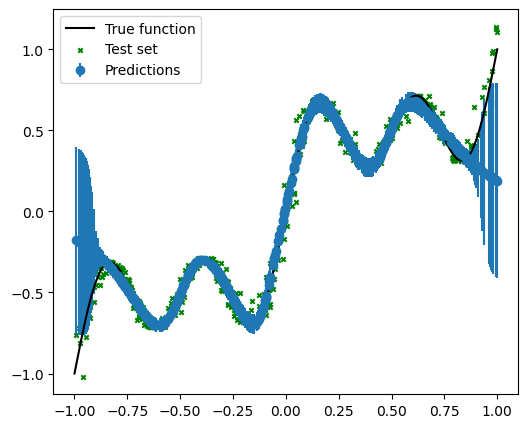

(tensor([[-0.1732],
        [ 0.0349],
        [ 0.1887]], device='cuda:0', grad_fn=<AddmmBackward>), tensor([[0.5767],
        [0.0608],
        [0.6024]], device='cuda:0', grad_fn=<SoftplusBackward>))


In [11]:
y_pred, sigma_pred = map(lambda x: x.cpu().data.numpy(), model_simple(X_test_tensor))

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.errorbar(X_test, y_pred, yerr=sigma_pred, ls='none', marker='o', label='Predictions')

plt.legend()

plt.show()

print(model_simple(torch.tensor([[-1.0], [0.0], [1.0]], device=device)))

In [ ]:
w1 = model_simple._modules['0'].weight.data
b1 = model_simple._modules['0'].bias.data

w2 = model_simple._modules['2'].weight.data
b2 = model_simple._modules['2'].bias.data

w3 = model_simple._modules['4'].weight.data
b3 = model_simple._modules['4'].bias.data

In [107]:
def copy_weights2(m1, m2):
    m2.layer1.W_mu.data = m1.layer1.weight.data
    m2.layer1.bias_mu.data = m1.layer1.bias.data

    m2.layer2.W_mu.data = m1.layer2.weight.data
    m2.layer2.bias_mu.data = m1.layer2.bias.data

    m2.layer3.W_mu.data[0:0, ] = m1.layer3.weight.data
    m2.layer3.bias_mu.data[0] = m1.layer3.bias.data[0]

In [108]:
copy_weights2(model_simple, model_reg)

In [ ]:
w1_b = model_reg.layer1.W_mu.cpu().data.numpy()
w2_b = model_reg.layer2.W_mu.cpu().data.numpy()
w3_b = model_reg.layer3.W_mu.cpu().data.numpy()

b1_b = model_reg.layer1.bias_mu.cpu().data.numpy()
b2_b = model_reg.layer2.bias_mu.cpu().data.numpy()
b3_b = model_reg.layer3.bias_mu.cpu().data.numpy()
